# Altermagnetic superconductors

In [1]:
import kwant
import matplotlib.pyplot as plt
import numpy as np
from amsc import bulk_amsc_system, generate_intial_Delta, setup_gaussian_impurities
from plot_tools import add_tl_label
from tqdm.notebook import tqdm
from pauli import *
from qm_tools import sparse_diag, sort_eigensystem
from plot_tools import multiplot

In [2]:
# eigsh = sla.eigsh
eigsh = sparse_diag  # MUMPS

In [3]:
plt.style.use("../plot_style.mplstyle")

# System Setup

In [4]:
periodic_bc = True

Nx = 81
Ny = 81

x_ax = np.linspace(-(Nx // 2), (Nx // 2), Nx)
y_ax = np.linspace(-(Ny // 2), (Ny // 2), Ny)
x, y = np.meshgrid(x_ax, y_ax)

t = 5.0
t_so = 0.0 * t
t_am = 0.25 * t

mu = 2.5
hz0 = 1e-6
hx0 = 0
hy0 = 0

## Initial value for Delta (will be used to determine g)
Delta_init = 1

In [5]:
vortex_positions = []
windings = []
l_core = 0  # l_core is the decay length of the order parameter (in a vortex that is the coherence length)

Delta, theta = generate_intial_Delta(
    x=x,
    y=y,
    Delta_init=Delta_init,
    vortex_positions=vortex_positions,
    windings=windings,
    l_core=l_core,
)

In [6]:
# Impurituy positions
impurity_positions = [(0, 0)]  # , (-10, 0)]
impurity_sizes = [2.2]  # Sizes
impurity_eccentricities = [0.0]  # Eccentricity
impurity_orientation = [0.0]  # Orientation


V_imp = [-19]  # Impurity potential (negative = attractive)
hx_imp = [0.0]  # Impurity field
hy_imp = [0.0]  # Impurity field
hz_imp = [0.0]  # Impurity field

## No spin-orbit coupling

In [7]:
N = 160

In [8]:
P = 11
hzs = np.linspace(-0.38, 0.38, P) + 1e-6
wss = np.zeros((P, N))
vss = np.zeros((P, 4 * Nx**2, N), dtype=complex)

for i, hz0 in tqdm(enumerate(hzs), total=len(hzs)):

    V, hx, hy, hz = setup_gaussian_impurities(
        x=x,
        y=y,
        mu=mu,
        hx0=hx0,
        hy0=hy0,
        hz0=hz0,
        impurity_sizes=impurity_sizes,
        impurity_positions=impurity_positions,
        impurity_eccentricities=impurity_eccentricities,
        impurity_orientations=impurity_orientation,
        V_imp=V_imp,
        hx_imp=hx_imp,
        hy_imp=hy_imp,
        hz_imp=hz_imp,
    )

    syst, lat = bulk_amsc_system(
        Nx=Nx,
        Ny=Ny,
        t=t,
        t_so=t_so,
        t_am=t_am,
        V=V,
        Delta=Delta,
        theta=theta,
        hx=hx,
        hy=hy,
        hz=hz,
        periodic_bc=periodic_bc,
    )

    fsyst = syst.finalized()

    ws, vs = eigsh(fsyst.hamiltonian_submatrix(sparse=True), k=N, sigma=0)

    wss[i] = ws
    vss[i] = vs

  0%|          | 0/11 [00:00<?, ?it/s]

In [9]:
t0sz_op = kwant.operator.Density(fsyst, onsite=t0sz, sum=False)
t0s0_op = kwant.operator.Density(fsyst, onsite=t0s0, sum=False)

In [10]:
wss, vss = sort_eigensystem(wss, vss)

In [11]:
idxs = (abs(wss[P // 2])).argsort()

szs = np.zeros((P, 4))

for n in range(4):
    for p in range(P):
        szs[p, n] = t0sz_op(vss[p, :, idxs[n]]).sum()

szs = szs.clip(-1, 1)

colors = np.zeros((P, N, 4))
colors[:] = (0.5, 0.5, 0.5, 0.3)

for p in range(P):
    for n in range(4):
        colors[p, idxs[n], :] = ((1 + szs[p, n]) / 2, 0, (1 - szs[p, n]) / 2, 1)

/tmp/ipykernel_107663/1279849376.py:23: RuntimeWarning: plotly is not available, if other engines are unavailable, only iterator-providing functions will work
  im1d = kwant.plotter.density(fsyst, d_1, ax=ax1, cmap=cmap, vmin=vmin, vmax=vmax, relwidth=relwidth)


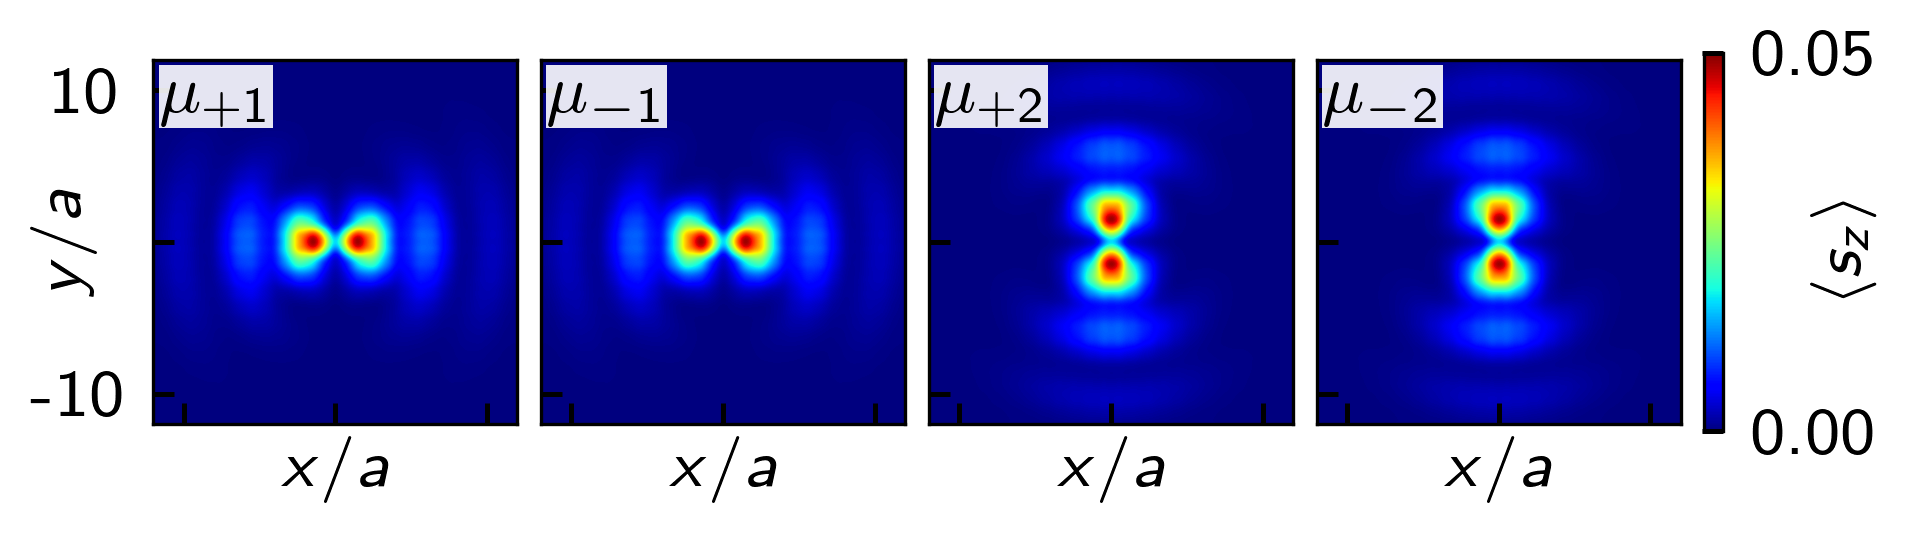

In [12]:
d_1 = t0s0_op(vss[P // 2, :, idxs[0]])
d_2 = t0s0_op(vss[P // 2, :, idxs[1]])
d_3 = t0s0_op(vss[P // 2, :, idxs[2]])
d_4 = t0s0_op(vss[P // 2, :, idxs[3]])

# Create figure and gridspace for subplots
fig = plt.figure(figsize=(3.375, 0.82))
gs = fig.add_gridspec(1, 5, width_ratios=[1, 1, 1, 1, 0.05], wspace=0.08, hspace=0.08)

# Determine color limits
vmax = np.max(np.abs([d_1, d_2, d_3, d_4]))
vmin = 0

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
cax = fig.add_subplot(gs[0, 4])

cmap = "jet"
relwidth = 0.035
im1d = kwant.plotter.density(fsyst, d_1, ax=ax1, cmap=cmap, vmin=vmin, vmax=vmax, relwidth=relwidth)
im2d = kwant.plotter.density(fsyst, d_2, ax=ax2, cmap=cmap, vmin=vmin, vmax=vmax, relwidth=relwidth)
im3d = kwant.plotter.density(fsyst, d_3, ax=ax3, cmap=cmap, vmin=vmin, vmax=vmax, relwidth=relwidth)
im4d = kwant.plotter.density(fsyst, d_4, ax=ax4, cmap=cmap, vmin=vmin, vmax=vmax, relwidth=relwidth)

# Set lims
xlims = (-12, 12)
ylims = (-12, 12)
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

# Remove axis labels for inner plots
ax1.set_yticks([-10, 0, 10], labels=["-10", "", "10"])
for ax in [ax2, ax3, ax4]:
    ax.set_yticks([-10, 0, 10], labels=[])

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xticks([-10, 0, 10], labels=[])  # labels=["-20", "", "20"])

ax1.set_ylabel(r"$y/a$", labelpad=-8)
ax1.set_xlabel(r"$x/a$", labelpad=-2)
ax2.set_xlabel(r"$x/a$", labelpad=-2)
ax3.set_xlabel(r"$x/a$", labelpad=-2)
ax4.set_xlabel(r"$x/a$", labelpad=-2)

# Adjust z-order and apply rasterization
for ax in [ax1, ax2, ax3, ax4]:
    ax.images[0].set_zorder(-1)
    ax.set_rasterization_zorder(0)
# Add titles for each subplot
add_tl_label(ax1, r"$\mu_{+1}$")
add_tl_label(ax2, r"$\mu_{-1}$")
add_tl_label(ax3, r"$\mu_{+2}$")
add_tl_label(ax4, r"$\mu_{-2}$")

# Create a common colorbar on the right
# fig.subplots_adjust(right=0.85, left=0.05, bottom=0.05, top=0.95)
cbar = fig.colorbar(ax1.images[0], cax=cax, cmap="RdBu_r")
cbar.set_ticks([vmin, vmax], labels=[f"{vmin:.2f}", f"{vmax:.2f}"])
cbar.set_label(r"$\langle s_z \rangle$", labelpad=-8)

# Adjust layout
# gs.tight_layout(fig)#, rect=[0, 0, 0.85, 1])

# Save the figure as SVG with rasterized content
fig.savefig("./imgs/Fig2_ldos_nonso_v19w22.svg", dpi=1200)

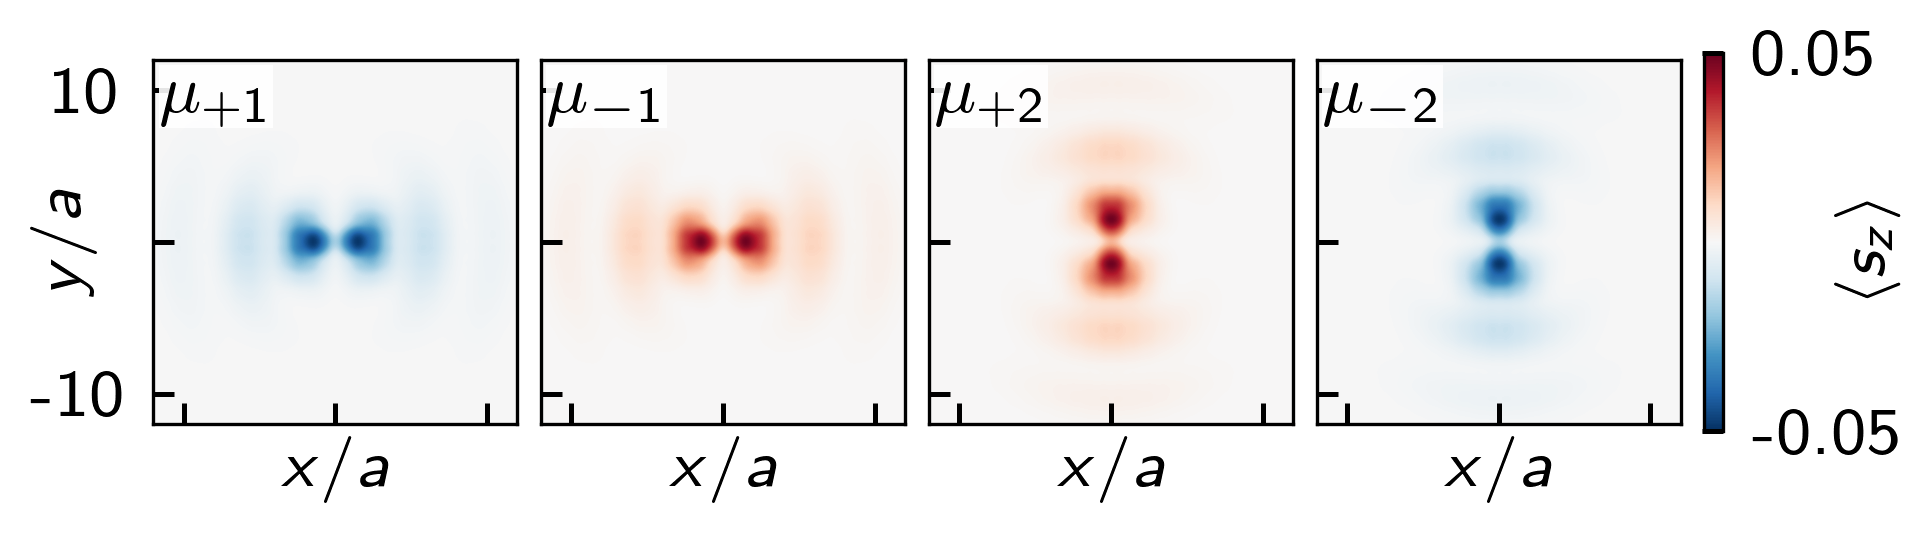

In [13]:
d_1 = t0sz_op(vss[P // 2, :, idxs[0]])
d_2 = t0sz_op(vss[P // 2, :, idxs[1]])
d_3 = t0sz_op(vss[P // 2, :, idxs[2]])
d_4 = t0sz_op(vss[P // 2, :, idxs[3]])

# Create figure and gridspace for subplots
fig = plt.figure(figsize=(3.375, 0.82))
gs = fig.add_gridspec(1, 5, width_ratios=[1, 1, 1, 1, 0.05], wspace=0.08, hspace=0.08)

# Determine color limits
vmax = np.max(np.abs([d_1, d_2, d_3, d_4]))
vmin = -vmax

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
cax = fig.add_subplot(gs[0, 4])

# Plot densities 
cmap="RdBu_r"
relwidth = 0.035
im1 = kwant.plotter.density(fsyst, d_1, ax=ax1, cmap=cmap, vmin=vmin, vmax=vmax, relwidth=relwidth)
im2 = kwant.plotter.density(fsyst, d_2, ax=ax2, cmap=cmap, vmin=vmin, vmax=vmax, relwidth=relwidth)
im3 = kwant.plotter.density(fsyst, d_3, ax=ax3, cmap=cmap, vmin=vmin, vmax=vmax, relwidth=relwidth)
im4 = kwant.plotter.density(fsyst, d_4, ax=ax4, cmap=cmap, vmin=vmin, vmax=vmax, relwidth=relwidth)

# Set lims
xlims = (-12, 12)
ylims = (-12, 12)
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

# Remove axis labels for inner plots
ax1.set_yticks([-10, 0, 10], labels=["-10", "", "10"])
for ax in [ax2, ax3, ax4]:
    ax.set_yticks([-10, 0, 10], labels=[])

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xticks([-10, 0, 10], labels=[])  # labels=["-20", "", "20"])

ax1.set_ylabel(r"$y/a$", labelpad=-8)
ax1.set_xlabel(r"$x/a$", labelpad=-2)
ax2.set_xlabel(r"$x/a$", labelpad=-2)
ax3.set_xlabel(r"$x/a$", labelpad=-2)
ax4.set_xlabel(r"$x/a$", labelpad=-2)

# Adjust z-order and apply rasterization
for ax in [ax1, ax2, ax3, ax4]:
    ax.images[0].set_zorder(-1)
    ax.set_rasterization_zorder(0)
# Add titles for each subplot
add_tl_label(ax1, r"$\mu_{+1}$")
add_tl_label(ax2, r"$\mu_{-1}$")
add_tl_label(ax3, r"$\mu_{+2}$")
add_tl_label(ax4, r"$\mu_{-2}$")

# Create a common colorbar on the right
# fig.subplots_adjust(right=0.85, left=0.05, bottom=0.05, top=0.95)
cbar = fig.colorbar(ax1.images[0], cax=cax, cmap="RdBu_r")
cbar.set_ticks([vmin, vmax], labels=[f"{vmin:.2f}", f"{vmax:.2f}"])
cbar.set_label(r"$\langle s_z \rangle$", labelpad=-8)

# Adjust layout
# gs.tight_layout(fig)#, rect=[0, 0, 0.85, 1])

# Save the figure as SVG with rasterized content
fig.savefig("./imgs/Fig2_sldos_nonso_v19w22.svg", format="svg", dpi=1200)

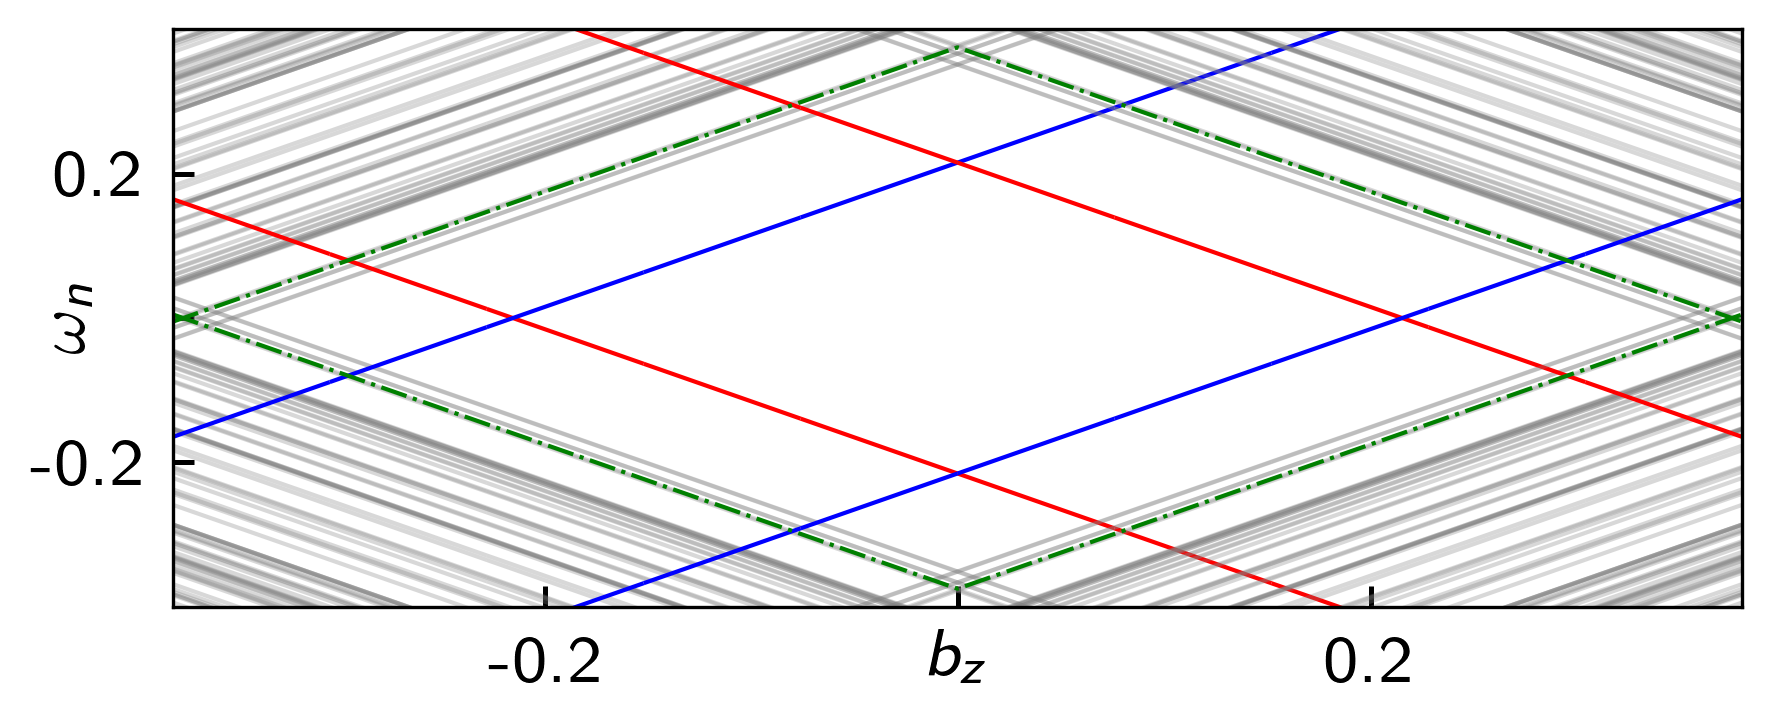

In [14]:
fig, ax = plt.subplots(figsize=(3.375, 1.25))

# for i in range(N):
#     ax.plot(hzs_so, wss_so[:, i], linestyle='-', marker='', color=colors[P_so//2, i])


multiplot(hzs, wss, colors=colors, linestyle="-")

ax.plot(hzs, Delta_init - mu * t_am / t - abs(hzs), "-.", color="green")
ax.plot(hzs, -Delta_init + mu * t_am / t + abs(hzs), "-.", color="green")

ax.set_xticks([-0.2, 0, 0.2], labels=["-0.2", "", "0.2"])
ax.set_yticks([-0.2, 0, 0.2], labels=["-0.2", "", "0.2"])

ax.set_xlabel(r"$b_z$", labelpad=-8)
ax.set_ylabel(r"$\omega_n$", labelpad=-8)
ax.set_ylim(-0.4, 0.4)
ax.set_xlim(-0.38, 0.38)

fig.savefig("./imgs/Fig2_noso_v19w22.svg", dpi=1200)

In [15]:
del wss
del vss

## Spin-orbit coupling

In [16]:
P_so = 31
hzs_so = np.linspace(-0.38, 0.38, P_so) + 1e-6
wss_so = np.zeros((P_so, N))
vss_so = np.zeros((P_so, 4 * Nx**2, N), dtype=complex)

for i, hz0 in tqdm(enumerate(hzs_so), total=len(hzs_so)):

    V, hx, hy, hz = setup_gaussian_impurities(
        x=x,
        y=y,
        mu=mu,
        hx0=hx0,
        hy0=hy0,
        hz0=hz0,
        impurity_sizes=impurity_sizes,
        impurity_positions=impurity_positions,
        impurity_eccentricities=impurity_eccentricities,
        impurity_orientations=impurity_orientation,
        V_imp=V_imp,
        hx_imp=hx_imp,
        hy_imp=hy_imp,
        hz_imp=hz_imp,
    )

    syst, lat = bulk_amsc_system(
        Nx=Nx,
        Ny=Ny,
        t=t,
        t_so=0.02 * t,
        t_am=t_am,
        V=V,
        Delta=Delta,
        theta=theta,
        hx=hx,
        hy=hy,
        hz=hz,
        periodic_bc=periodic_bc,
    )

    fsyst = syst.finalized()

    ws, vs = eigsh(fsyst.hamiltonian_submatrix(sparse=True), k=N, sigma=0)

    wss_so[i] = ws
    vss_so[i] = vs

  0%|          | 0/31 [00:00<?, ?it/s]

In [17]:
wss_so, vss_so = sort_eigensystem(wss_so, vss_so)

In [18]:
idxs_so = (abs(wss_so[P_so // 2])).argsort()

t0sz_op = kwant.operator.Density(fsyst, onsite=t0sz, sum=False)

szs_so = np.zeros((P_so, 4))

for n in range(4):
    for p in range(P_so):
        szs_so[p, n] = t0sz_op(vss_so[p, :, idxs_so[n]]).sum()

szs_so = szs_so.clip(-1, 1)

colors_so = np.zeros((P_so, N, 4))
colors_so[:] = (0.5, 0.5, 0.5, 0.3)

for p in range(P_so):
    for n in range(4):
        colors_so[p, idxs_so[n], :] = (
            (1 + szs_so[p, n]) / 2,
            0,
            (1 - szs_so[p, n]) / 2,
            1,
        )

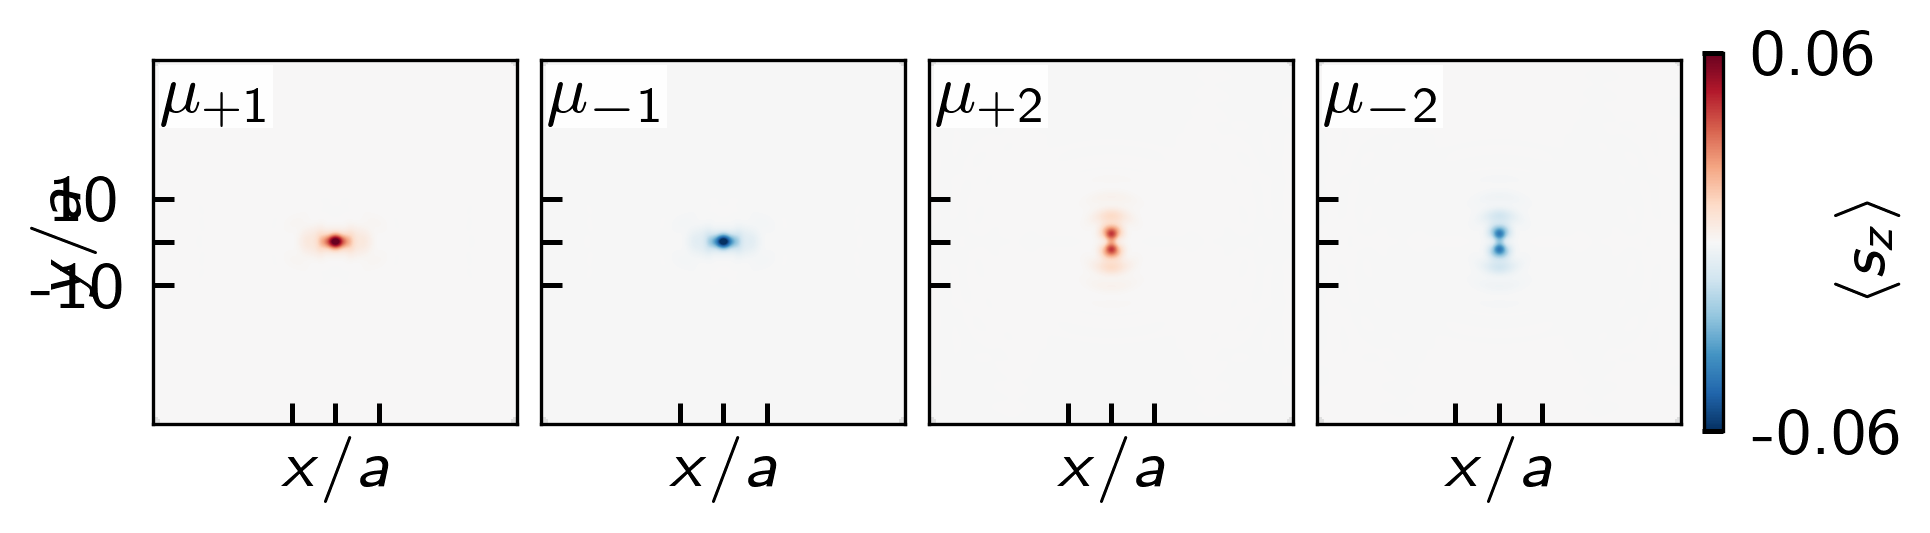

In [19]:
d_1 = t0sz_op(vss_so[P // 2, :, idxs_so[0]])
d_2 = t0sz_op(vss_so[P // 2, :, idxs_so[1]])
d_3 = t0sz_op(vss_so[P // 2, :, idxs_so[2]])
d_4 = t0sz_op(vss_so[P // 2, :, idxs_so[3]])

# Create figure and gridspace for subplots
fig = plt.figure(figsize=(3.375, 0.82))
gs = fig.add_gridspec(1, 5, width_ratios=[1, 1, 1, 1, 0.05], wspace=0.08, hspace=0.08)

# Determine color limits
vmax = np.max(np.abs([d_1, d_2, d_3, d_4]))
vmin = -vmax

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
cax = fig.add_subplot(gs[0, 4])

# Plot densities with kwant.plotter.density
im1 = kwant.plotter.density(fsyst, d_1, ax=ax1, cmap="RdBu_r", vmin=vmin, vmax=vmax)
im2 = kwant.plotter.density(fsyst, d_2, ax=ax2, cmap="RdBu_r", vmin=vmin, vmax=vmax)
im3 = kwant.plotter.density(fsyst, d_3, ax=ax3, cmap="RdBu_r", vmin=vmin, vmax=vmax)
im4 = kwant.plotter.density(fsyst, d_4, ax=ax4, cmap="RdBu_r", vmin=vmin, vmax=vmax)

# Set lims
# xlims = (-12, 12)
# ylims = (-12, 12)
# for ax in [ax1, ax2, ax3, ax4]:
#     ax.set_xlim(xlims)
#     ax.set_ylim(ylims)

# Remove axis labels for inner plots
ax1.set_yticks([-10, 0, 10], labels=["-10", "", "10"])
for ax in [ax2, ax3, ax4]:
    ax.set_yticks([-10, 0, 10], labels=[])

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xticks([-10, 0, 10], labels=[])  # labels=["-20", "", "20"])


ax1.set_ylabel(r"$y/a$", labelpad=-8)
ax1.set_xlabel(r"$x/a$", labelpad=-2)
ax2.set_xlabel(r"$x/a$", labelpad=-2)
ax3.set_xlabel(r"$x/a$", labelpad=-2)
ax4.set_xlabel(r"$x/a$", labelpad=-2)

# Adjust z-order and apply rasterization
for ax in [ax1, ax2, ax3, ax4]:
    ax.images[0].set_zorder(-1)
    ax.set_rasterization_zorder(0)
# Add titles for each subplot
add_tl_label(ax1, r"$\mu_{+1}$")
add_tl_label(ax2, r"$\mu_{-1}$")
add_tl_label(ax3, r"$\mu_{+2}$")
add_tl_label(ax4, r"$\mu_{-2}$")

# Create a common colorbar on the right
# fig.subplots_adjust(right=0.85, left=0.05, bottom=0.05, top=0.95)
cbar = fig.colorbar(ax1.images[0], cax=cax, cmap="RdBu_r")
cbar.set_ticks([vmin, vmax], labels=[f"{vmin:.2f}", f"{vmax:.2f}"])
cbar.set_label(r"$\langle s_z \rangle$", labelpad=-8)

# Adjust layout
# gs.tight_layout(fig)#, rect=[0, 0, 0.85, 1])

# Save the figure as SVG with rasterized content
fig.savefig("./imgs/Fig2_sldos_19w22.svg", format="svg", dpi=1200)

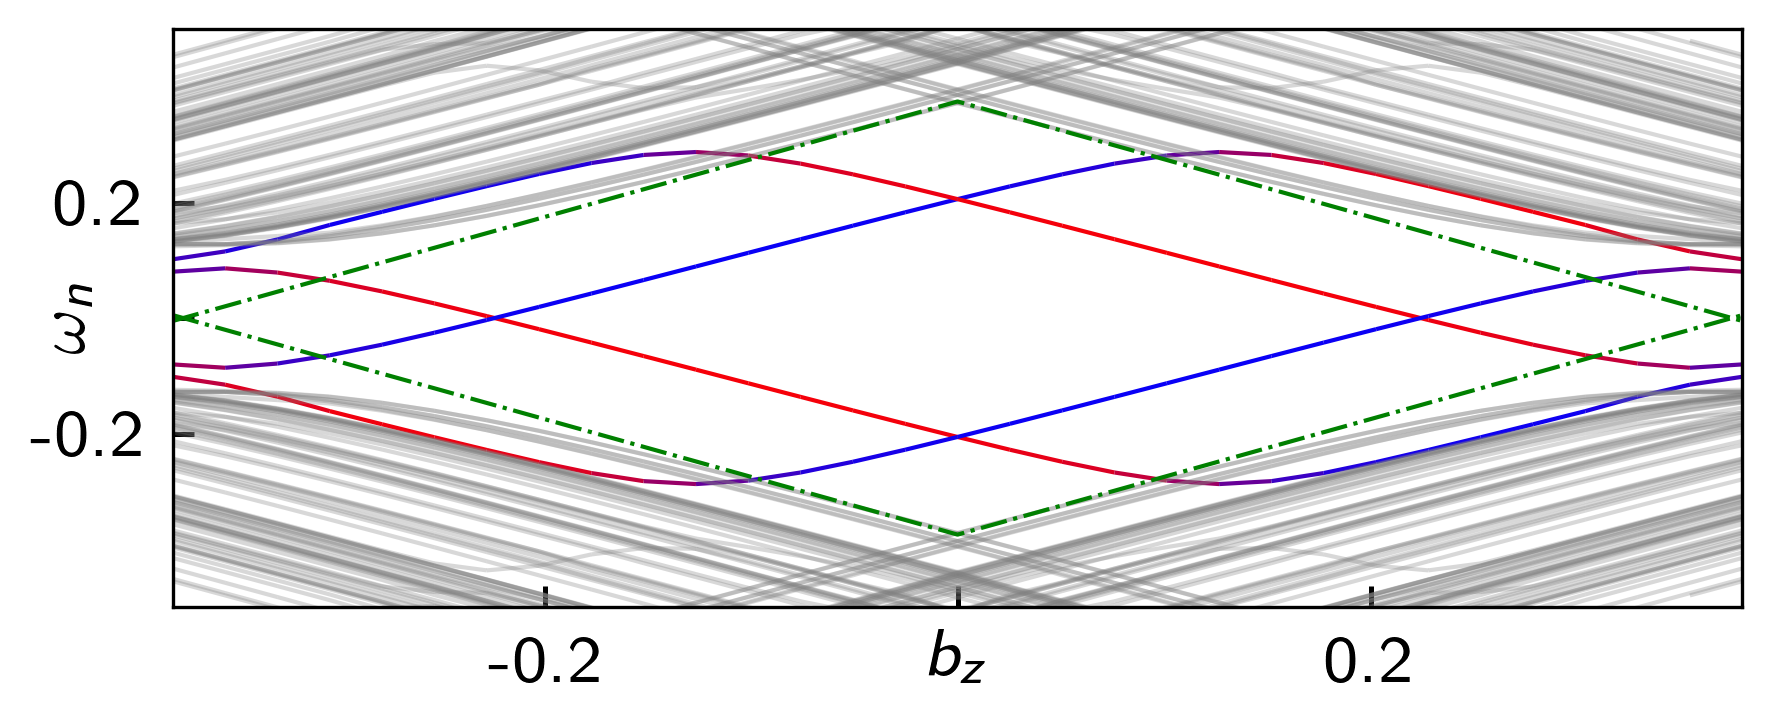

In [20]:
fig, ax = plt.subplots(figsize=(3.375, 1.25))

# for i in range(N):
#     ax.plot(hzs_so, wss_so[:, i], linestyle='', marker='.')


multiplot(hzs_so, wss_so, colors=colors_so)

ax.plot(hzs_so, Delta_init - mu * t_am / t - abs(hzs_so), "-.", color="green")
ax.plot(hzs_so, -Delta_init + mu * t_am / t + abs(hzs_so), "-.", color="green")

ax.set_xticks([-0.2, 0, 0.2], labels=["-0.2", "", "0.2"])
ax.set_yticks([-0.2, 0, 0.2], labels=["-0.2", "", "0.2"])

ax.set_xlabel(r"$b_z$", labelpad=-8)
ax.set_ylabel(r"$\omega_n$", labelpad=-8)
ax.set_ylim(-0.5, 0.5)
ax.set_xlim(-0.38, 0.38)

fig.savefig("./imgs/Fig2_so_v19w22.svg", dpi=1200)